# Imports

In [0]:
import pandas as pd
import numpy as np
import re
import tensorflow.compat.v2 as tf 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sb

tf.version.VERSION

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.2.0-rc3'

In [0]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

# Preprocessing methods

In [0]:
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]','',text)
    return text

Proccesing method

In [0]:
def preprocess_train(data, functions):
    _data = pd.DataFrame(data['SentimentText'])
    for function in functions:
        _data['SentimentText'] = _data['SentimentText'].apply(lambda x: function(x))
    _row_sizes = _data['SentimentText'].str.split().str.len()
    print(f"Words count: {pd.Series.sum(_row_sizes)}")
    print(_data)
    return _data

# AMAZON

## Load Data

### Train data

In [0]:
path = "../data/AmazonTrainSet1M.tsv"
amazonData = pd.read_csv(path, sep='\t', header=0, encoding="utf-8")
row_sizes = amazonData['SentimentText'].str.split().str.len()
amazonData['SentimentText'] = amazonData['SentimentText'].str.lower()
print(f"Words count: {pd.Series.sum(row_sizes)}")
amazonData

Words count: 78450202


,Sentiment,SentimentText
0,0,defective: i was really excited to get the fis...
1,1,m-audio 2496 sound card: excellent sound card ...
2,0,missing links: it's a shame the quality of thi...
3,0,tribute album: this is a tribute album...i did...
4,1,pretty good: it does taste pretty good and is ...
...,...,...
999995,1,tlc...... need i say more: tlc is the best gro...
999996,1,alternative ending: an excellent book no doubt...
999997,1,p-town series: i read these out of order becau...
999998,0,pretty sad....: this book would play out bette...


### Test data

In [0]:
import csv
path = "../data/AmazonTestSet400k2.tsv"
testData = pd.read_csv(path, sep='\t', header=0, encoding="utf-8") # , quoting=csv.QUOTE_NONE
row_sizes = testData['SentimentText'].str.split().str.len()
testData['SentimentText'] = testData['SentimentText'].str.lower()
print(f"Words count: {pd.Series.sum(row_sizes)}")
testData

Words count: 31369658


,Sentiment,SentimentText
0,1,this is a great book: i must preface this by s...
1,0,"huge disappointment.: as a big time, long term..."
2,1,wayne is tight but cant hang with turk.: this ...
3,1,excellent: i read this book when i was in elem...
4,0,not about anusara: although this book is toute...
...,...,...
399995,0,you can fool all the people some of the time b...
399996,0,it was good but not good: it was an 'okay' boo...
399997,0,unwatchable: the product arrived promptly and ...
399998,0,not worth the money or the time to read.: the ...


### Validation data

In [0]:
path = "../data/AmazonValidationSet100K.tsv"
validation_data = pd.read_csv(path, sep='\t', header=0, encoding="utf-8") # , quoting=csv.QUOTE_NONE
row_sizes = validation_data['SentimentText'].str.split().str.len()
validation_data['SentimentText'] = validation_data['SentimentText'].str.lower()
print(f"Words count: {pd.Series.sum(row_sizes)}")
validation_data

Words count: 7826428


,Sentiment,SentimentText
0,0,just another political opinion disguised as hi...
1,0,the big bad maniac magee review: i did not lik...
2,1,a good cable: the cable does exactly what it i...
3,0,it stinks!: it's so bad it should come with a ...
4,0,do women really take this seriously?: i picked...
...,...,...
99995,1,nice surprise: expecting this older mystery to...
99996,0,huh?: i fail to see the purpose of this book. ...
99997,0,don't buy this cirque du (school)!: i love cir...
99998,1,"soft-edged, just a bit undercharacterized: bou..."


## Preprocessing

In [0]:
df = preprocess_train(amazonData, [])

Words count: 78450202
                                            SentimentText
0       defective: i was really excited to get the fis...
1       m-audio 2496 sound card: excellent sound card ...
2       missing links: it's a shame the quality of thi...
3       tribute album: this is a tribute album...i did...
4       pretty good: it does taste pretty good and is ...
...                                                   ...
999995  tlc...... need i say more: tlc is the best gro...
999996  alternative ending: an excellent book no doubt...
999997  p-town series: i read these out of order becau...
999998  pretty sad....: this book would play out bette...
999999  awesome funky jazz band, definetly check them ...

[1000000 rows x 1 columns]


### Feature extraction for embedding layer

In [0]:
df['review_lenght'] = np.array(list(map(lambda x: len(x.split()), df['SentimentText'])))
median = df['review_lenght'].median()
mean = df['review_lenght'].mean()
_max_length = df['review_lenght'].max()

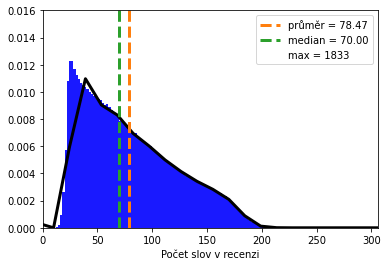

In [0]:
fig, ax = plt.subplots()
sb.distplot( df['review_lenght'],  bins=int(_max_length/2),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=_max_length/6)
ax.set_xlabel('Počet slov v recenzi')
ymax = 0.016
plt.ylim(0, ymax)
ax.plot([mean, mean], [0, ymax], '--', label=f'průměr = {mean:.2f}', linewidth=3)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=3)
ax.plot([_max_length, _max_length], [0, ymax], '--', label=f'max = {_max_length}', linewidth=0)
# ax.set_title('Distribuce slov v recenzích', fontsize=20)
plt.legend()
plt.show()

In [0]:
max_dictionary_size = 10000
tokenizer = Tokenizer(num_words=max_dictionary_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(df['SentimentText'])
# train data
list_tokenized_train = tokenizer.texts_to_sequences(df['SentimentText'])
max_length = 180
X_t = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
y = amazonData['Sentiment']
len(tokenizer.index_word)

502158

In [0]:
# test data
list_tokenized_train = tokenizer.texts_to_sequences(testData['SentimentText'])
X_test = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
y_test = testData['Sentiment']

In [0]:
# validation data
list_tokenized_train = tokenizer.texts_to_sequences(validation_data['SentimentText'])
X_valid = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
y_valid = validation_data['Sentiment']

## LSTM model

In [0]:
model = keras.models.Sequential([
  keras.layers.Embedding(max_dictionary_size, 64, input_length=max_length),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.4),
  keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)),
  keras.layers.GlobalMaxPooling1D(),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(100),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(1, activation="sigmoid")                                
])

model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=4,
                                        verbose=1,
                                        mode='auto',
                                        restore_best_weights=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 180, 64)           640000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 180, 64)           256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 180, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 180, 200)          132000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

Epoch 1/12
7813/7813 [==============================] - 256s 33ms/step - loss: 0.2005 - accuracy: 0.9209 - val_loss: 0.1565 - val_accuracy: 0.9408
Epoch 2/12
7813/7813 [==============================] - 255s 33ms/step - loss: 0.1579 - accuracy: 0.9406 - val_loss: 0.1502 - val_accuracy: 0.9462
Epoch 3/12
7813/7813 [==============================] - 254s 33ms/step - loss: 0.1456 - accuracy: 0.9458 - val_loss: 0.1422 - val_accuracy: 0.9482
Epoch 4/12
7813/7813 [==============================] - 254s 33ms/step - loss: 0.1378 - accuracy: 0.9492 - val_loss: 0.1472 - val_accuracy: 0.9487
Epoch 5/12
7813/7813 [==============================] - 257s 33ms/step - loss: 0.1315 - accuracy: 0.9518 - val_loss: 0.1512 - val_accuracy: 0.9483
Epoch 6/12
7813/7813 [==============================] - 256s 33ms/step - loss: 0.1269 - accuracy: 0.9537 - val_loss: 0.1378 - val_accuracy: 0.9492
Epoch 7/12
7813/7813 [==============================] - 257s 33ms/step - loss: 0.1224 - accuracy: 0.9555 - val_loss: 0

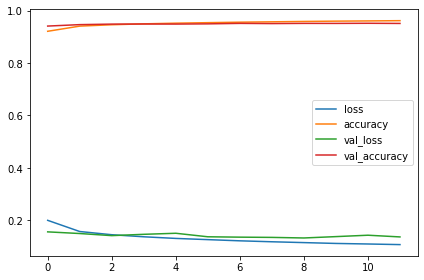

In [0]:
history = model.fit(X_t,y, batch_size=128, epochs=12, validation_data=(X_valid, y_valid), callbacks=[early_stopping])
show_history(history)

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: ', test_acc)

12500/12500 [==============================] - 99s 8ms/step - loss: 0.1396 - accuracy: 0.9500
Test accuracy:  0.9500250220298767


## LSTM model 2

In [0]:
model = keras.models.Sequential([
    keras.layers.Embedding(max_dictionary_size, 64, input_length=max_length, mask_zero=True),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(),
    keras.layers.Dropout(0.3),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")                             
])

model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=4,
                                        verbose=1,
                                        mode='auto',
                                        restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 64)           640000    
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 64)           256       
_________________________________________________________________
dropout (Dropout)            (None, 180, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 180, 128)          66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 180, 128)          512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 90, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 128)           0

In [0]:
history = model.fit(X_t,y, batch_size=256, epochs=12, validation_data=(X_valid, y_valid), callbacks=[early_stopping])
show_history(history)

Epoch 1/12
1506/3907 [==========>...................] - ETA: 6:31 - loss: 0.2585 - accuracy: 0.8918

UnknownError: ignored

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: ', test_acc)


## CNN deep model **2**

In [0]:
model = keras.models.Sequential([
  keras.layers.Embedding(max_dictionary_size, 64, input_length=max_length),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.3),
  keras.layers.Conv1D(32, 7, padding='same', activation='relu'),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.3),
  keras.layers.Conv1D(32, 3, padding='same', activation='relu'),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.3),
  keras.layers.Conv1D(32, 3, padding='same', activation='relu'),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.3),
  keras.layers.Conv1D(32, 3, padding='same', activation='relu'),
  keras.layers.Dropout(0.3),
  keras.layers.Conv1D(2, 2),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1, activation="sigmoid")                                
])

model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 180, 64)           640000    
_________________________________________________________________
batch_normalization_4 (Batch (None, 180, 64)           256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 180, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 180, 32)           14368     
_________________________________________________________________
batch_normalization_5 (Batch (None, 180, 32)           128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 180, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 180, 32)          

Epoch 1/12
7813/7813 [==============================] - 120s 15ms/step - loss: 0.2053 - accuracy: 0.9210 - val_loss: 0.1622 - val_accuracy: 0.9403
Epoch 2/12
7813/7813 [==============================] - 120s 15ms/step - loss: 0.1682 - accuracy: 0.9373 - val_loss: 0.1555 - val_accuracy: 0.9422
Epoch 3/12
7813/7813 [==============================] - 120s 15ms/step - loss: 0.1570 - accuracy: 0.9422 - val_loss: 0.1525 - val_accuracy: 0.9443
Epoch 4/12
7813/7813 [==============================] - 120s 15ms/step - loss: 0.1502 - accuracy: 0.9446 - val_loss: 0.1504 - val_accuracy: 0.9452
Epoch 5/12
7813/7813 [==============================] - 119s 15ms/step - loss: 0.1448 - accuracy: 0.9471 - val_loss: 0.1500 - val_accuracy: 0.9452
Epoch 6/12
7813/7813 [==============================] - 119s 15ms/step - loss: 0.1402 - accuracy: 0.9489 - val_loss: 0.1507 - val_accuracy: 0.9452
Epoch 7/12
7813/7813 [==============================] - 119s 15ms/step - loss: 0.1371 - accuracy: 0.9502 - val_loss: 0

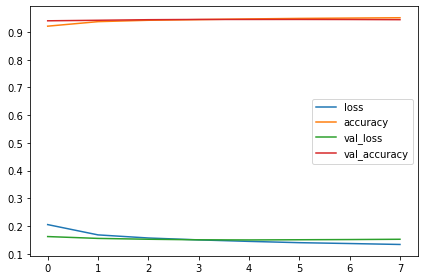

In [0]:
history = model.fit(X_t,y, batch_size=128, epochs=12, validation_data=(X_valid, y_valid), callbacks=[early_stopping])
show_history(history)

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: ', test_acc)

12500/12500 [==============================] - 42s 3ms/step - loss: 0.1519 - accuracy: 0.9444
Test accuracy:  0.9444375038146973


## CNN model

In [0]:
filters = 250
kernel_size = 3

model = keras.models.Sequential([
  keras.layers.Embedding(max_dictionary_size, 50, input_length=max_length),
  keras.layers.Dropout(0.3),
  keras.layers.Conv1D(filters, kernel_size, activation="relu"),
  keras.layers.GlobalMaxPooling1D(),
  keras.layers.Dense(250),
  keras.layers.Dropout(0.2),
  keras.layers.Activation("relu"),
  keras.layers.Dense(1, activation="sigmoid")                                
])

model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=3,
                                        verbose=1,
                                        mode='auto',
                                        restore_best_weights=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 180, 50)           500000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 180, 50)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 178, 250)          37750     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation (Activation)      (None, 250)              

Epoch 1/12
7813/7813 [==============================] - 153s 20ms/step - loss: 0.2097 - accuracy: 0.9156 - val_loss: 0.1739 - val_accuracy: 0.9331
Epoch 2/12
7813/7813 [==============================] - 152s 19ms/step - loss: 0.1698 - accuracy: 0.9349 - val_loss: 0.1608 - val_accuracy: 0.9389
Epoch 3/12
7813/7813 [==============================] - 152s 19ms/step - loss: 0.1565 - accuracy: 0.9407 - val_loss: 0.1600 - val_accuracy: 0.9395
Epoch 4/12
7813/7813 [==============================] - 153s 20ms/step - loss: 0.1475 - accuracy: 0.9447 - val_loss: 0.1576 - val_accuracy: 0.9405
Epoch 5/12
7813/7813 [==============================] - 152s 20ms/step - loss: 0.1401 - accuracy: 0.9477 - val_loss: 0.1606 - val_accuracy: 0.9400
Epoch 6/12
7813/7813 [==============================] - 152s 19ms/step - loss: 0.1342 - accuracy: 0.9500 - val_loss: 0.1568 - val_accuracy: 0.9405
Epoch 7/12
7813/7813 [==============================] - 152s 19ms/step - loss: 0.1287 - accuracy: 0.9522 - val_loss: 0

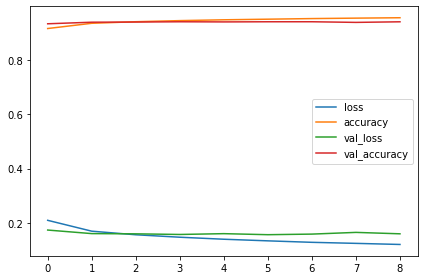

In [0]:
history = model.fit(X_t,y, batch_size=128, epochs=12, validation_data=(X_valid, y_valid), callbacks=[early_stopping])
show_history(history)

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: ', test_acc)

12500/12500 [==============================] - 45s 4ms/step - loss: 0.1593 - accuracy: 0.9395
Test accuracy:  0.939520001411438
